# Logistic Regression for Space Weather Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import arviz as az
import multiprocessing        
from sklearn.preprocessing import LabelEncoder

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
space_weather_df = pd.read_csv('Space_Weather.csv')
print(space_weather_df.columns)
dtype = {
    'BSRN': 'float32', 
    'ND': 'float32', 
    'KP_SUM': 'float32', 
    'AP_AVG': 'float32',
    'CP': 'float32', 
    'C9': 'float32', 
    'ISN': 'float32', 
    'F10.7_OBS': 'float32',
    'F10.7_ADJ': 'float32', 
    'F10.7_OBS_CENTER81': 'float32', 
    'F10.7_OBS_LAST81': 'float32',
    'F10.7_ADJ_CENTER81': 'float32', 
    'F10.7_ADJ_LAST81': 'float32',
    'F10.7_DATA_TYPE': 'category',
    'Geomagnetic_Storm': 'category',
    'Solar_Flare_Detection': 'int32',
    'Activity_Type': 'category'
}

# Correctly convert the 'DATE' column to datetime format
space_weather_df['DATE'] = pd.to_datetime(space_weather_df['DATE'], dayfirst=True)

# Now convert other columns types as specified
space_weather_df = space_weather_df.astype(dtype)
        

Index(['DATE', 'BSRN', 'ND', 'KP_SUM', 'AP_AVG', 'CP', 'C9', 'ISN',
       'F10.7_OBS', 'F10.7_ADJ', 'KP1', 'AP1', 'KP2', 'AP2', 'KP3', 'AP3',
       'KP4', 'AP4', 'KP5', 'AP5', 'KP6', 'AP6', 'KP7', 'AP7', 'KP8', 'AP8',
       'F10.7_OBS_CENTER81', 'F10.7_OBS_LAST81', 'F10.7_ADJ_CENTER81',
       'F10.7_ADJ_LAST81', 'F10.7_DATA_TYPE', 'Geomagnetic_Storm',
       'Solar_Flare_Detection', 'Activity_Type'],
      dtype='object')


In [4]:
print(space_weather_df.head())

        DATE  BSRN        ND    KP_SUM    AP_AVG        CP        C9  \
0 2000-01-01  0.42  0.462380  0.499399  0.960782  0.648720  0.144274   
1 2000-01-02  0.58  0.430591  0.932934  0.078520  0.558700  0.469506   
2 2000-01-03  0.32  0.490096  0.212742  0.281228  0.613091  0.975808   
3 2000-01-04  0.52  0.483932  0.364209  0.494099  0.887551  0.247206   
4 2000-01-05  0.64  0.253961  0.329851  0.170308  0.868245  0.703101   

        ISN   F10.7_OBS   F10.7_ADJ  ...       KP8        AP8  \
0  0.412698  104.100136  137.692459  ...  0.151015  67.191521   
1  0.349206  116.006523   95.218697  ...  2.696456   3.577513   
2  0.507937  144.873810   94.712036  ...  3.953092  57.538329   
3  0.666667  129.061905  166.211365  ...  4.916377  41.797592   
4  0.507937  150.901627  120.484367  ...  6.145471  23.716346   

   F10.7_OBS_CENTER81  F10.7_OBS_LAST81  F10.7_ADJ_CENTER81  F10.7_ADJ_LAST81  \
0          171.774872        151.169495           74.792542        169.436508   
1          132

In [5]:
# Converting and encoding categorical variables for probabilistic analysis
space_weather_df['DATE'] = pd.to_datetime(space_weather_df['DATE'])
space_weather_df['F10.7_DATA_TYPE'] = pd.Categorical(space_weather_df['F10.7_DATA_TYPE'])
space_weather_df['Geomagnetic_Storm'] = pd.Categorical(space_weather_df['Geomagnetic_Storm'])
space_weather_df['Activity_Type'] = LabelEncoder().fit_transform(space_weather_df['Activity_Type'])

In [6]:
# Defining features to normalize
features_to_normalize = ['BSRN', 'ND', 'KP_SUM', 'AP_AVG', 'CP', 'C9', 'ISN', 'F10.7_OBS', 'F10.7_ADJ']
space_weather_df['Geomagnetic_Storm_Codes'] = space_weather_df['Geomagnetic_Storm'].cat.codes

# Including the encoded 'Activity_Type' and 'Geomagnetic_Storm_Codes' in the list of features to be used
features = features_to_normalize + ['Activity_Type', 'Geomagnetic_Storm_Codes']
target = 'Solar_Flare_Detection'

# Data Normalization
scaler = StandardScaler()
X = scaler.fit_transform(space_weather_df[features])
y = space_weather_df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Apply dimension Reduction using PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [8]:
# Initialize and train the logistic regression model
logistic_reg = LogisticRegression(random_state=42)
logistic_reg.fit(X_train_pca, y_train)
y_pred = logistic_reg.predict(X_test_pca)

Accuracy: 100.00%


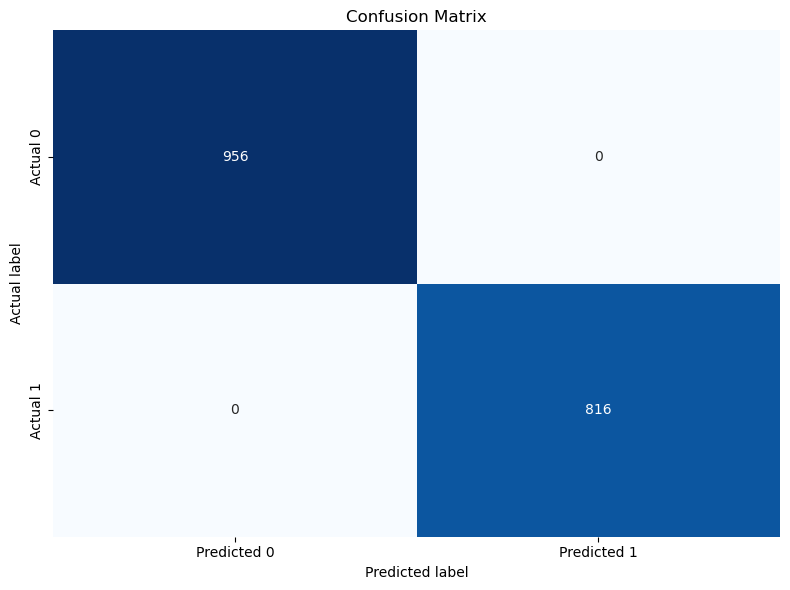

In [9]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

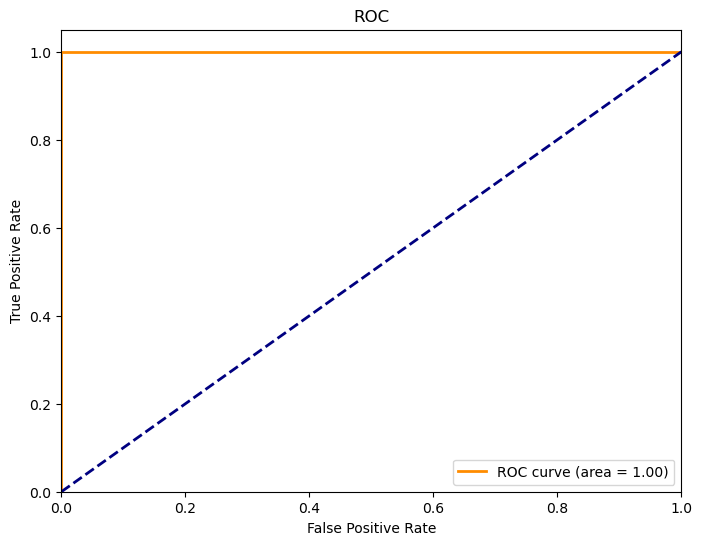

In [10]:
# Calculate the ROC
fpr, tpr, thresholds = roc_curve(y_test, logistic_reg.predict_proba(X_test_pca)[:, 1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()